In [4]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


from scipy.sparse import lil_matrix
import scipy
from collections import defaultdict
import operator
import math
%matplotlib inline

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
people = pd.read_csv('10k-people-raw.csv', sep=';')

In [7]:
vip = []
print('Name\t\t\t', 'Index')
for index, name in enumerate(people['Name']):
    if name == 'Michael Schumacher':
        vip.append((index, 'Michael Schumacher'))
        print('Michael Schumacher:\t', index)
    if name == 'Albert Einstein':
        vip.append((index, 'Albert Einstein'))
        print('Albert Einstein:\t', index)
    if name == 'Michael Jackson':
        vip.append((index, 'Michael Jackson'))
        print('Michael Jackson:\t', index)

Name			 Index
Michael Schumacher:	 3
Albert Einstein:	 215
Michael Jackson:	 1951


In [8]:
print(vip)

[(3, 'Michael Schumacher'), (215, 'Albert Einstein'), (1951, 'Michael Jackson')]


In [9]:
print(people['text'][3][:600])
print()
print(people['text'][215][:600])
print()
print(people['text'][1951][:600])

Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Michael Schumacher (* 3. Januar 1969 in Hürth-Hermülheim, Nordrhein-Westfalen) ist ein ehemaliger deutscher Automobilrennfahrer. Schumacher startete von 1991 bis 2006 sowie von 2010 bis 2012 zu insgesamt 307 Großen Preisen der Formel-1-Weltmeisterschaft. Mit sieben Weltmeistertiteln, 91 Siegen, 68 Pole-Positions und 77 schnellsten Rennrunden ist er der erfolgreichste Pilot der Formel-1-Geschichte. Darüber hinaus stand er mit 155 Platzierungen unter den Top drei am häufigsten auf dem Siegerpodest. Nachdem Schumacher 1990 und 1991 in der Spo

Albert Einstein (* 14. März 1879 in Ulm; † 18. April 1955 in Princeton, New Jersey) war ein theoretischer Physiker. Seine Forschungen zur Struktur von Materie, Raum und Zeit sowie dem Wesen der Gravitation veränderten maßgeblich das physikalische Weltbild. Er gilt daher als einer der bedeutendsten Physiker aller Zeiten. Einsteins Hauptwerk, die Relativitätstheorie, machte ihn weltberühmt. Im Jah

In [10]:
import nltk
stem = nltk.stem.snowball.SnowballStemmer('german')

In [11]:
text = people['text'][1951][:600]
stemmed_text_example = []
stemmed_text_example.append(' '.join([stem.stem(word.lower()) for word in nltk.word_tokenize(str(text.encode('utf8')))
                              if word.isalpha() ]))

In [12]:
stemmed_text_example

['joseph jackson august in gary indiana juni in los angel kaliforni war ein komponist und entertain aufgrund sein erfolg wird er als of bezeichnet jackson gilt mit weltweit etwa bis million verkauft laut der rekord als erfolgreich entertain all zeit and quell geb sogar bis zu million abgesetzt platt an postum verkauft sich innerhalb ein jahr nach sein tod weit million sein alb jackson wurd bereit als kind teil der in d']

####  Vielleicht wollen Sie das Pre-Processing etwas verbessern um Umlaut  (ä --> ae, ... ), Wort-Verbindungen (US-amerikanisch, Guinness-Buch, ... ) etc.  zu "retten"

In [13]:
stopwords = set()
with open("GermanST.txt", "r") as f:
    stopwords = set([word.lower().strip() for word in f.readlines()])

In [14]:
class Preprocessor:
    def __init__(self, texts):
        self.word_dict = dict()
        self.word_stopped_dict = dict()
        self.stemmed_dict = dict()
        self.stemmed_stoppped_dict = dict()

        self.all_words = []
        self.words_stopped = []
        self.words_stemmed = []
        self.words_stemmed_stopped = []

        i = 0
        k = 0
        j = 0
        l = 0

        for doc_id, text in enumerate(texts):
            self.all_words.append([])
            self.words_stopped.append([])
            self.words_stemmed.append([])
            self.words_stemmed_stopped.append([])

            for word in nltk.word_tokenize(str(text.encode('utf8'))):
                if not word.isalpha(): continue
                word = word.replace(u"ö", "oe").replace(u"ü", "ue").replace(u"ä", "ae").lower()
                if word not in self.word_dict:
                    self.word_dict[word] = i
                    i += 1
                    if word not in stopwords:
                        self.word_stopped_dict[word] = j
                        j += 1

                stemmed = stem.stem(word)
                if stemmed not in self.stemmed_dict:
                    self.stemmed_dict[stemmed] = k
                    k += 1
                    if stemmed not in stopwords:
                        self.stemmed_stoppped_dict[stemmed] = l
                        l += 1

                self.all_words[-1].append(word)
                if word not in stopwords:
                    self.words_stopped[-1].append(word)

                self.words_stemmed[-1].append(stemmed)
                if stemmed not in stopwords:
                    self.words_stemmed_stopped[-1].append(stemmed)

In [15]:
preprocessor = Preprocessor(people['text'])

In [17]:
print(len(preprocessor.word_dict))
print(len(preprocessor.word_stopped_dict))
print(len(preprocessor.stemmed_dict))
print(len(preprocessor.stemmed_stoppped_dict))

298054
297555
222679
222435


In [24]:
def cos_dist(a: np.ndarray, b: np.ndarray):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def scalar(a: np.ndarray, b: np.ndarray):
    return np.dot(a, b)

In [18]:
class Document:
    def __init__(self, doc):
        self.doc = doc

    def bow_similarity(self, id: int, use_cos_dist=False):
        sims = []

        for i in range(self.doc.shape[0]):
            if i == id: continue
            a = self.doc[id, :].toarray().flatten()
            b = self.doc[i, :].toarray().flatten()
            if use_cos_dist:
                sims.append((i, cos_dist(a, b)))
            else:
                sims.append((i, scalar(a, b)))

        return list(sorted(sims, key=lambda sim: sim[1], reverse=True))

    def print_best_10(self, id, use_cos_dist=False, with_text=True):
        for sim in self.bow_similarity(id, use_cos_dist=use_cos_dist)[:10]:
            idx = sim[0]
            print(people['Name'][idx])
            if with_text:
                print(people['text'][idx][:400])
            print(f"similarity: {sim[1]}")
            print()

In [16]:
class BagOfWord(Document):
    def __init__(self, word_array, word_dict):
        bag_of_words = lil_matrix((len(word_array), len(word_dict)))
        print(bag_of_words.shape)

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                bag_of_words[i, idx] = 1

        super().__init__(bag_of_words)

# 1) Zipf law

In [17]:
word_dict = defaultdict(int)
word_count = 0
word_index = {}

i = 0
for text in people['text']:
    for word in nltk.word_tokenize(str(text.encode('utf8'))):
        if not word.isalpha(): continue
        w = stem.stem(word.lower())
        word_dict[w] += 1
        word_count += 1
        if w not in word_index:
            word_index[w] = i
            i += 1

In [18]:
rel_dict = defaultdict(float)
rank = []

for key, value in sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True):
    rel_dict[key] = value / word_count
    rank.append(rel_dict[key])

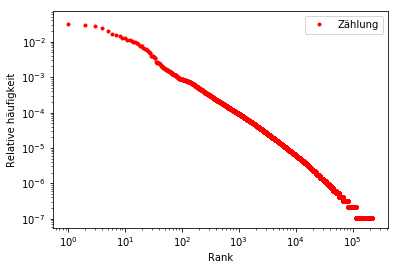

In [19]:
fig, ax = plt.subplots()
plt_rank = plt.plot(np.arange(len(rank)), rank, 'r.', label="Zählung")
plt.xlabel('Rank')
plt.ylabel('Relative häufigkeit')
plt.legend(["Zählung", "Zipf law"])
ax.set_yscale("log", nonposy='clip')
ax.set_xscale("log")

# 2) Bag of Words

In [20]:
class BagOfWord(Document):
    def __init__(self, word_array, word_dict):
        bag_of_words = lil_matrix((len(word_array), len(word_dict)))
        print(bag_of_words.shape)

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                bag_of_words[i, idx] = 1

        super().__init__(bag_of_words)

In [21]:
bow = BagOfWord(preprocessor.all_words, preprocessor.word_dict)

(10000, 298054)


### Schumacher

In [22]:
# 3 Schumacher
bow.print_best_10(3, use_cos_dist=False)

Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius z Valdštejna (* 24. September 1583 in Hermanitz an der Elbe, Böhmen; † 25. Februar 1634 in Eger, Böhmen), war ein böhmischer Feldherr und Politiker. Er war Herzog von Friedland und Sagan, von 1628 bis 1631 als Albrecht VIII. Herzog zu Mecklenburg, Fürst zu Wenden, Graf von Schwerin, Herr von Rostoc
similarity: 691.0

Theobald von Bethmann Hollweg
Theobald Theodor Friedrich Alfred von Bethmann Hollweg (* 29. November 1856 in Hohenfinow, Provinz Brandenburg; † 2. Januar 1921 ebenda) war ein deutscher Politiker in der Zeit des Kaiserreichs. Seine Karriere begann als Verwaltungsbeamter und gipfelte in der Amtszeit als Reichskanzler von 1909 bis 1917. Theobald von Bethmann Hollweg vertrat liberale Auffassungen und stand der Fortschrittlichen Vo
similarity: 652.0

Fernando Alonso
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Fernando Alonso Díaz (* 29. Juli 1981 in Oviedo

## Einstein

In [23]:
# 215 Einstein
bow.print_best_10(215, use_cos_dist=False)

Benjamin Franklin
Benjamin Franklin (* 17. Januar 1706 in Boston, Massachusetts; † 17. April 1790 in Philadelphia, Pennsylvania) war ein amerikanischer Drucker, Verleger, Schriftsteller, Naturwissenschaftler, Erfinder und Staatsmann. Als einer der Gründerväter der Vereinigten Staaten beteiligte er sich am Entwurf der Unabhängigkeitserklärung der Vereinigten Staaten und war einer ihrer Unterzeichner. Während der Ame
similarity: 512.0

Theobald von Bethmann Hollweg
Theobald Theodor Friedrich Alfred von Bethmann Hollweg (* 29. November 1856 in Hohenfinow, Provinz Brandenburg; † 2. Januar 1921 ebenda) war ein deutscher Politiker in der Zeit des Kaiserreichs. Seine Karriere begann als Verwaltungsbeamter und gipfelte in der Amtszeit als Reichskanzler von 1909 bis 1917. Theobald von Bethmann Hollweg vertrat liberale Auffassungen und stand der Fortschrittlichen Vo
similarity: 492.0

Max Liebermann
Max Liebermann (* 20. Juli 1847 in Berlin; † 8. Februar 1935 ebenda) war ein deutscher Maler und 

## Jackson

In [24]:
# 1951 Jackson
bow.print_best_10(1951, use_cos_dist=False)

Marlon Brando
Marlon Brando, Jr. (* 3. April 1924 in Omaha, Nebraska; † 1. Juli 2004 in Los Angeles, Kalifornien) war ein amerikanischer Schauspieler. Er gilt als einer der bedeutendsten Charakterdarsteller der Filmgeschichte des 20. Jahrhunderts. Mit seinen Rollen in den Filmen Endstation Sehnsucht (1951) und Die Faust im Nacken (1954) verschaffte er der Schauspieltechnik des Method Acting weltweit Beachtung. 
similarity: 280.0

Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius z Valdštejna (* 24. September 1583 in Hermanitz an der Elbe, Böhmen; † 25. Februar 1634 in Eger, Böhmen), war ein böhmischer Feldherr und Politiker. Er war Herzog von Friedland und Sagan, von 1628 bis 1631 als Albrecht VIII. Herzog zu Mecklenburg, Fürst zu Wenden, Graf von Schwerin, Herr von Rostoc
similarity: 273.0

Mahatma Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamchand Gāndhī; gen

# 3) Bag of Words without stop words

In [25]:
bow_stopped = BagOfWord(preprocessor.words_stopped, preprocessor.word_stopped_dict)

(10000, 297555)


## Schumacher

In [29]:
# 3 Schumacher
bow_stopped.print_best_10(3, use_cos_dist=False, with_text=False)

Fernando Alonso
similarity: 446.0

Wallenstein
similarity: 436.0

Lewis Hamilton
similarity: 403.0

Theobald von Bethmann Hollweg
similarity: 396.0

Benjamin Franklin
similarity: 383.0

Herbert C. Hoover
similarity: 376.0

Herbert Hoover
similarity: 376.0

Florence Nightingale
similarity: 373.0

Sebastian Vettel
similarity: 363.0

Marlon Brando
similarity: 359.0



## Einstein

In [30]:
# 215 Einstein
bow_stopped.print_best_10(215, use_cos_dist=False, with_text=False)

Benjamin Franklin
similarity: 319.0

Theobald von Bethmann Hollweg
similarity: 298.0

Max Liebermann
similarity: 298.0

Otto Hahn
similarity: 291.0

Florence Nightingale
similarity: 290.0

Max Planck
similarity: 287.0

Herbert C. Hoover
similarity: 282.0

Herbert Hoover
similarity: 282.0

Mahatma Gandhi
similarity: 280.0

Mohandas Karamchand Gandhi
similarity: 280.0



## Jackson

In [31]:
# 1951 Jackson
bow_stopped.print_best_10(1951, use_cos_dist=False, with_text=False)

Marlon Brando
similarity: 140.0

Mahatma Gandhi
similarity: 134.0

Mohandas Karamchand Gandhi
similarity: 134.0

Madonna (Künstlerin)
similarity: 130.0

Maria I. (England)
similarity: 127.0

Wallenstein
similarity: 126.0

Michael Schumacher
similarity: 125.0

Benjamin Franklin
similarity: 124.0

Ulrike Meinhof
similarity: 124.0

George Washington
similarity: 122.0



# 4a) Term frequency without stop words

In [25]:
class UnaryCounts(Document):
    def __init__(self, word_array, word_dict):
        tfidf = lil_matrix((len(word_array), len(word_dict)))
        print(tfidf.shape)

        word_counts = defaultdict(int)

        for i in range(len(word_array)):
            for word in word_array[i]:
                word_counts[word] += 1

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                tfidf[i, idx] = word_counts[word]

        super().__init__(tfidf)

In [26]:
unaryCounts = UnaryCounts(preprocessor.words_stopped, preprocessor.word_stopped_dict)

(10000, 297555)


In [27]:
#tfidf_stopped = tf_idf(use_stopword=True, do_stem=False)

# 3 Schumacher
print("Schumacher")
unaryCounts.print_best_10(3, use_cos_dist=False, with_text=False)
print()

# 215 Einstein
print("Einstein")
unaryCounts.print_best_10(215, use_cos_dist=False, with_text=False)
print()

# 1951 Jackson
print("Jackson")
unaryCounts.print_best_10(1951, use_cos_dist=False, with_text=False)

Schumacher
Benjamin Franklin
similarity: 2598735696.0

Andrea Bocelli
similarity: 2583506746.0

Marlon Brando
similarity: 2554206278.0

Herbert C. Hoover
similarity: 2529632275.0

Herbert Hoover
similarity: 2529632275.0

Theobald von Bethmann Hollweg
similarity: 2499806857.0

Winston Churchill
similarity: 2460778259.0

Rudolf Heß
similarity: 2456355636.0

James Dean
similarity: 2446655097.0

Florence Nightingale
similarity: 2436494889.0


Einstein
Benjamin Franklin
similarity: 2874616136.0

Wilhelm Solf
similarity: 2823351764.0

Otto Hahn
similarity: 2804855093.0

Marlon Brando
similarity: 2800053349.0

Herbert C. Hoover
similarity: 2788851877.0

Herbert Hoover
similarity: 2788851877.0

Paul Klee
similarity: 2769078170.0

Aleister Crowley
similarity: 2761132035.0

Klaus Mann
similarity: 2737632311.0

Georges Simenon
similarity: 2728091978.0


Jackson
Miles Davis
similarity: 1784743167.0

Marlon Brando
similarity: 1749770060.0

Liza Minnelli
similarity: 1722272387.0

Benjamin Franklin
s

# 4b) Term frequency without stop words and with stemming

In [28]:
unaryCounts_stemmed = UnaryCounts(preprocessor.words_stemmed_stopped, preprocessor.stemmed_stoppped_dict)

(10000, 222435)


In [29]:
#tfidf_stopped_stemmed = tf_idf(use_stopword=True, do_stem=True)

# 3 Schumacher
print("Schumacher")
unaryCounts_stemmed.print_best_10(3, use_cos_dist=False, with_text=False)
print()

# 215 Einstein
print("Einstein")
unaryCounts_stemmed.print_best_10(215, use_cos_dist=False, with_text=False)
print()

# 1951 Jackson
print("Jackson")
unaryCounts_stemmed.print_best_10(1951, use_cos_dist=False, with_text=False)

Schumacher
Benjamin Franklin
similarity: 19951698050.0

Marlon Brando
similarity: 19854920354.0

Theobald von Bethmann Hollweg
similarity: 19840791612.0

Herbert C. Hoover
similarity: 19827271899.0

Herbert Hoover
similarity: 19827271899.0

Andrea Bocelli
similarity: 19782337236.0

Mahatma Gandhi
similarity: 19767815554.0

Mohandas Karamchand Gandhi
similarity: 19767815554.0

Florence Nightingale
similarity: 19752251121.0

Algernon Sidney
similarity: 19746623670.0


Einstein
Benjamin Franklin
similarity: 20456385600.0

Marlon Brando
similarity: 20378223173.0

Theobald von Bethmann Hollweg
similarity: 20326406815.0

Herbert C. Hoover
similarity: 20311987429.0

Herbert Hoover
similarity: 20311987429.0

Wilhelm Solf
similarity: 20293883325.0

Aleister Crowley
similarity: 20211060376.0

Klaus Mann
similarity: 20170791732.0

Otto Hahn
similarity: 20170126706.0

Max Liebermann
similarity: 20135608518.0


Jackson
Marlon Brando
similarity: 18078807143.0

Miles Davis
similarity: 18060987465.0



# 4c) Term frequency, stopped, stemmed and Cosine Similarity

In [30]:
# 3 Schumacher
print("Schumacher")
unaryCounts_stemmed.print_best_10(3, use_cos_dist=True, with_text=False)
print()

# 215 Einstein
print("Einstein")
unaryCounts_stemmed.print_best_10(215, use_cos_dist=True, with_text=False)
print()

# 1951 Jackson
print("Jackson")
unaryCounts_stemmed.print_best_10(1951, use_cos_dist=True, with_text=False)

Schumacher
Cristiano Ronaldo
similarity: 0.9519432662333485

James Milner
similarity: 0.942564279985034

Niccolò Machiavelli
similarity: 0.9415381681723292

Wallenstein
similarity: 0.9415295263869948

Samuel Hebich
similarity: 0.9402452335553713

Winston Churchill
similarity: 0.9394810770700806

Oskar Antze
similarity: 0.9393390293050043

Robert Schumann
similarity: 0.9392619948525286

Andreas Widhölzl
similarity: 0.9392077644872104

Georg Friedrich Händel
similarity: 0.9388172752417516


Einstein
Edith Junghans
similarity: 0.954188400622444

Wilhelm Solf
similarity: 0.9532085882360078

Marc Chagall
similarity: 0.9529788179138012

Paul Klee
similarity: 0.9529216456071233

Carl Gustav Jung
similarity: 0.9528037318771195

Pablo Picasso
similarity: 0.9526973258587595

Aleister Crowley
similarity: 0.951700552990253

Max Planck
similarity: 0.9510904213565963

Max Frisch
similarity: 0.9509948089718618

Percy Ernst Schramm
similarity: 0.9503814424170425


Jackson
Gary Michael Heidnik
similari

# 5) TF-IDF

In [31]:
class TfIdf(Document):
    def __init__(self, word_array, word_dict):
        num_docs = people.shape[0]
        idf_dict = defaultdict(int)

        tfidf = lil_matrix((len(word_array), len(word_dict)))
        print(tfidf.shape)

        word_count = defaultdict(int)

        for i in range(len(word_array)):
            ws = set()
            for word in word_array[i]:
                word_count[word] += 1
                if word not in ws:
                    ws.add(word)

            for w in ws:
                idf_dict[w] += 1

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                tfidf[i, idx] = word_count[word] * (1 + math.log(num_docs / idf_dict[word]))

        super().__init__(tfidf)

In [32]:
tfidf = TfIdf(preprocessor.words_stemmed_stopped, preprocessor.stemmed_stoppped_dict)

(10000, 222435)


In [33]:
# 3 Schumacher
print("Schumacher")
tfidf.print_best_10(3, use_cos_dist=True, with_text=False)
print()

# 215 Einstein
print("Einstein")
tfidf.print_best_10(215, use_cos_dist=True, with_text=False)
print()

# 1951 Jackson
print("Jackson")
tfidf.print_best_10(1951, use_cos_dist=True, with_text=False)

Schumacher
Cristiano Ronaldo
similarity: 0.8621551363642515

Andreas Widhölzl
similarity: 0.838589244618848

Fernando Alonso
similarity: 0.8363815676767452

James Milner
similarity: 0.8301115679725974

Georg Friedrich Händel
similarity: 0.8269966427958464

George Frideric Handel
similarity: 0.8269966427958464

Beatrix Potter
similarity: 0.8255050756766815

David Seaman
similarity: 0.8242160557478618

Sebastian Vettel
similarity: 0.824145600836881

Wallenstein
similarity: 0.8240350689434287


Einstein
Edith Junghans
similarity: 0.8538749404532807

Carl Gustav Jung
similarity: 0.8531702282992385

Paul Klee
similarity: 0.8517449159187851

Max Planck
similarity: 0.851562240713417

Wilhelm Solf
similarity: 0.8512543476276822

Pablo Picasso
similarity: 0.8490565922035472

Marc Chagall
similarity: 0.8483333994768917

Max Frisch
similarity: 0.8480540690156841

Aleister Crowley
similarity: 0.8464016351667035

Thomas Mann
similarity: 0.846081700837326


Jackson
Gary Michael Heidnik
similarity: 0

# 6a) LSA with k=100

In [43]:
s, e, u = scipy.sparse.linalg.svds(tfidf.doc.transpose(), k=100)

In [44]:
print(f"a: {tfidf.doc.shape}")
print(f"s: {s.shape}")
print(f"e: {e.shape}")
print(f"u: {u.shape}")

a: (10000, 222435)
s: (222435, 100)
e: (100,)
u: (100, 10000)


In [45]:
epsilon = np.diag(e)
#termns = np.dot(s, epsilon)
lsa_documents_100 = np.dot(epsilon, u)

In [46]:
def lsa_similarity(id:int, docs, use_cos_dist=False):
    sims = []
    for i in range(docs.shape[1]):
        if i == id: continue
        a = docs[:,id].flatten()
        b = docs[:, i].flatten()
        sims.append((i, cos_dist(a, b)))
                    
    return list(sorted(sims, key=lambda sim: sim[1], reverse=True))

def print_best_10_lsa(id, docs, with_text=True):
    for sim in lsa_similarity(id, docs)[:10]:
        idx = sim[0]
        print(people['Name'][idx])
        if with_text:
            print(people['text'][idx][:400])
        print(f"similarity: {sim[1]}")
        print()

In [47]:
# 3 Schumacher
print("Schumacher")
print_best_10_lsa(3, lsa_documents_100, with_text=False)
print()

# 215 Einstein
print("Einstein")
print_best_10_lsa(215, lsa_documents_100, with_text=False)
print()

# 1951 Jackson
print("Jackson")
print_best_10_lsa(1951, lsa_documents_100, with_text=False)

Schumacher
Cristiano Ronaldo
similarity: 0.9470341930245585

Georg Friedrich Händel
similarity: 0.9267193955262509

George Frideric Handel
similarity: 0.9267193955262509

Beatrix Potter
similarity: 0.9260246605115227

James Milner
similarity: 0.9232957805936491

Andrea Bocelli
similarity: 0.9214268183764369

Andreas Widhölzl
similarity: 0.921272750290895

Rudolf Harbig
similarity: 0.9212332899258109

Niccolò Machiavelli
similarity: 0.9209740167999139

Oskar Antze
similarity: 0.9201364629555047


Einstein
Edith Junghans
similarity: 0.9665521662449934

Paul Klee
similarity: 0.9614407094338931

Marc Chagall
similarity: 0.9609960800785907

Carl Gustav Jung
similarity: 0.9595012669435928

Aleister Crowley
similarity: 0.9588366573683919

Max Planck
similarity: 0.9576619802927677

George Grosz
similarity: 0.9567232914103972

Wilhelm Solf
similarity: 0.9564898732558504

Pablo Picasso
similarity: 0.9561888310784141

Konrad Adenauer
similarity: 0.9551118102657501


Jackson
Gary Michael Heidnik
s

# 6b) LSA with k=500

In [48]:
s, e, u = scipy.sparse.linalg.svds(tfidf.doc.transpose(), k=500)
epsilon = np.diag(e)
lsa_documents_500 = np.dot(epsilon, u)

In [49]:
# 3 Schumacher
print("Schumacher")
print_best_10_lsa(3, lsa_documents_500, with_text=False)
print()

# 215 Einstein
print("Einstein")
print_best_10_lsa(215, lsa_documents_500, with_text=False)
print()

# 1951 Jackson
print("Jackson")
print_best_10_lsa(1951, lsa_documents_500, with_text=False)

Schumacher
Cristiano Ronaldo
similarity: 0.8917416673221519

Georg Friedrich Händel
similarity: 0.8670082739036856

George Frideric Handel
similarity: 0.867008273903685

Andreas Widhölzl
similarity: 0.8659925128135592

Wallenstein
similarity: 0.8627405837500177

Beatrix Potter
similarity: 0.86168554638648

James Milner
similarity: 0.8604329040847465

Fernando Alonso
similarity: 0.8598743826952799

George Washington
similarity: 0.8594308139110487

Niccolò Machiavelli
similarity: 0.8580297021649945


Einstein
Wilhelm Solf
similarity: 0.8859269229092839

Carl Gustav Jung
similarity: 0.8846307733032939

Edith Junghans
similarity: 0.8840761469643836

Max Planck
similarity: 0.8827529087117073

Pablo Picasso
similarity: 0.8811529700573212

Marc Chagall
similarity: 0.8804059191481933

Max Frisch
similarity: 0.8802815175833163

Paul Klee
similarity: 0.8792057448683713

Percy Ernst Schramm
similarity: 0.8784015336317806

Aleister Crowley
similarity: 0.8781942168037606


Jackson
Gary Michael Heid

# 6c) LSA with k=1000

In [50]:
s, e, u = scipy.sparse.linalg.svds(tfidf.doc.transpose(), k=1000)
epsilon = np.diag(e)
lsa_documents_1000 = np.dot(epsilon, u)

In [51]:
# 3 Schumacher
print("Schumacher")
print_best_10_lsa(3, lsa_documents_1000, with_text=False)
print()

# 215 Einstein
print("Einstein")
print_best_10_lsa(215, lsa_documents_1000, with_text=False)
print()

# 1951 Jackson
print("Jackson")
print_best_10_lsa(1951, lsa_documents_1000, with_text=False)

Schumacher
Cristiano Ronaldo
similarity: 0.8806935820073338

Georg Friedrich Händel
similarity: 0.8547440306973657

George Frideric Handel
similarity: 0.8547440306973657

Andreas Widhölzl
similarity: 0.8535004105694695

Wallenstein
similarity: 0.8518495538431375

Fernando Alonso
similarity: 0.8496498657265799

Beatrix Potter
similarity: 0.8487202920548599

James Milner
similarity: 0.8480033745017613

George Washington
similarity: 0.8474425306255802

Benjamin Franklin
similarity: 0.8457154014944657


Einstein
Wilhelm Solf
similarity: 0.8742161656869935

Carl Gustav Jung
similarity: 0.8709373245504278

Edith Junghans
similarity: 0.8694878690846903

Max Planck
similarity: 0.8691472143337184

Pablo Picasso
similarity: 0.8676219050223912

Marc Chagall
similarity: 0.866742825259238

Max Frisch
similarity: 0.8667036819141825

Paul Klee
similarity: 0.8664570480065127

Percy Ernst Schramm
similarity: 0.8653054217245475

Max Liebermann
similarity: 0.8646956881917285


Jackson
Gary Michael Heidni